## Library Imports

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import math
import itertools
import xlrd
import random

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import StandardScaler

In [3]:
#heavy weight classifier tools
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.neural_network import MLPClassifier

## Function Definition

In [29]:
def random_cm(X, y, num_tests):
    # cm_list is a list of confusion matrices for the different random splits of the dataset
    cm_list = []
    
    for i in range(0,num_tests):
        X_train_loop, X_test_loop, y_train_loop, y_test_loop = train_test_split(X, y, test_size=0.3, random_state=random.randint(1,1000))

        # train a logistic regression classifier
        clf_loop = GaussianNB().fit(X_train_loop, y_train_loop) #(C=1.0).fit(X_train_loop, y_train_loop)

        # predict on train and test set
        y_train_predict_loop = clf_loop.predict(X_train_loop)
        y_test_predict_loop = clf_loop.predict(X_test_loop)
        cm_list.append(confusion_matrix(y_test_loop, y_test_predict_loop))
    
    # sum the confusion matrices and return the combined confusion matrix
    combined_cm = pd.Panel(cm_list).sum(axis=0)
    
    # validate return type
    assert isinstance(combined_cm, pd.DataFrame), "return type"
    
    return combined_cm

In [12]:
def plot_confusion_matrix(cm):
    # plot the confusion matrix
    plt.figure(figsize=(10,10))
    plt.matshow(cm, fignum=1)
    
    # add labels for all targets
    num_targets = cm.shape[0]
    plt.xticks(list(range(num_targets+1)))
    plt.yticks(list(range(num_targets+1)))

In [95]:
def hyperparameter_Reg(X, y):
    # result_list is a list of tuples (of train and test accuracy for each preset regularization threshold
    result_list = []
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random.randint(1,1000))
    
    for param in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
        
        clf_loop = LogisticRegression(C=param).fit(X_train, y_train)
        
        y_train_predict = clf_loop.predict(X_train)
        y_test_predict = clf_loop.predict(X_test)
        
        train_accuracy = accuracy_score(y_train, y_train_predict)
        test_accuracy = accuracy_score(y_test, y_test_predict)
        
        # add to result_list
        result_list.append((param, train_accuracy, test_accuracy))
        
    # Make a dataframe of the results
    result_df = pd.DataFrame(result_list, columns=["param", "train_accuracy", "test_accuracy"])
    
    # validate return type
    assert isinstance(result_df, pd.DataFrame), "return type"
    
    return result_df

In [110]:
def hyperparameter_RanFor(X, y):
    # result_list is a list of tuples (of train and test accuracy for each preset regularization threshold
    result_list = []
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random.randint(1,1000))
    n_est = [1500]
    max_dep = [10, 15, 20]
    
    for i in n_est:
        for j in max_dep:
        
            clf_loop = RandomForestClassifier(n_estimators=i, max_depth=j, random_state=random.randint(1,1000))
            clf_loop.fit(X_train, y_train)
        
            y_train_predict = clf_loop.predict(X_train)
            y_test_predict = clf_loop.predict(X_test)
        
            train_accuracy = accuracy_score(y_train, y_train_predict)
            test_accuracy = accuracy_score(y_test, y_test_predict)
        
            # add to result_list
            result_list.append((i, j, train_accuracy, test_accuracy))
        
    # Make a dataframe of the results
    result_df = pd.DataFrame(result_list, columns=["Number of Estimators", "Max Depth", "train_accuracy", "test_accuracy"])
    
    # validate return type
    assert isinstance(result_df, pd.DataFrame), "return type"
    
    return result_df

## Data Loading and Classifier Training (first pass)

In [4]:
labeledDF = pd.read_excel('Labelled_Data.xlsx', sheet_name='Output')

In [32]:
X = labeledDF.loc[:, labeledDF.columns != 'Building_Typology']
y = labeledDF.loc[:, labeledDF.columns == 'Building_Typology']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random.randint(1,1000))

In [44]:
# train a logistic regression classifier
clf = LogisticRegression(C=1.0).fit(X_train, y_train)

# predict on train and test set
y_train_predict = clf.predict(X_train)
y_test_predict = clf.predict(X_test)

# calculate train and test accuracy
train_accuracy = accuracy_score(y_train, y_train_predict)
test_accuracy = accuracy_score(y_test, y_test_predict)

# report results
print("Train accuracy: {}".format(train_accuracy))
print("Test accuracy: {}".format(test_accuracy))

Train accuracy: 0.661749209694
Test accuracy: 0.641728134879


C:\Anaconda\envs\warmup\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  


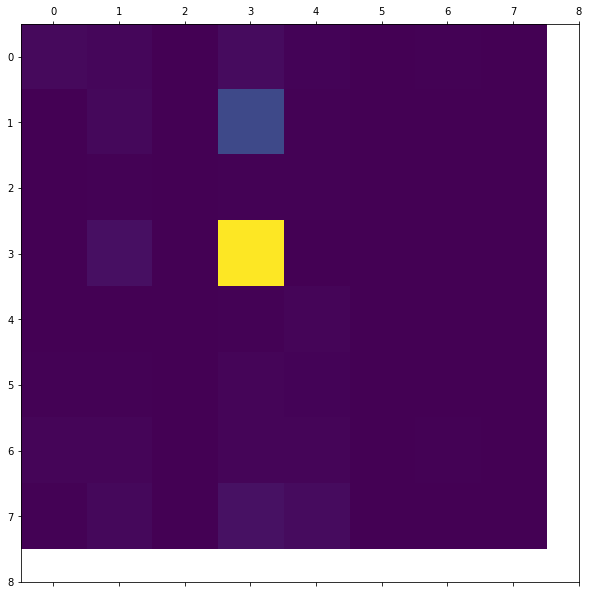

In [54]:
#for plotting the confusion matrix
cm10 = random_cm(X, y, num_tests = 10)
plot_confusion_matrix(cm10)

## Classifier Using a Random Forest Ensemble

In [46]:
clf2 = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=42)

In [67]:
#modifying input as necessary
X_train2 = X_train.drop(['Latitude Quadrant', 'Longitude Quadrant'], axis=1).copy()
X_test2 = X_test.drop(['Latitude Quadrant', 'Longitude Quadrant'], axis=1).copy()

In [48]:
#WITH LAT AND LON SECTOR
# predict on train and test set (random forest)
y_train_predict2 = clf2.predict(X_train2)
y_test_predict2 = clf2.predict(X_test2)

# calculate train and test accuracy
train_accuracy2 = accuracy_score(y_train, y_train_predict2)
test_accuracy2 = accuracy_score(y_test, y_test_predict2)

# report results
print("Train accuracy: {}".format(train_accuracy2))
print("Test accuracy: {}".format(test_accuracy2))

Train accuracy: 0.853530031612
Test accuracy: 0.71057253249


In [70]:
#WITHOUT LAT AND LON SECTOR
# predict on train and test set (random forest)
y_train_predict2 = clf2.predict(X_train2)
y_test_predict2 = clf2.predict(X_test2)

# calculate train and test accuracy
train_accuracy2 = accuracy_score(y_train, y_train_predict2)
test_accuracy2 = accuracy_score(y_test, y_test_predict2)

# report results
print("Train accuracy: {}".format(train_accuracy2))
print("Test accuracy: {}".format(test_accuracy2))

#slightly lower, it was learning something from the sector after all

Train accuracy: 0.832003612826
Test accuracy: 0.68387776607


In [52]:
#we're not just naively guessing Detached house!
np.unique(y_test_predict2)

array([u'Apartment', u'Attached House', u'Commercial', u'Detached House',
       u'Industrial', u'Institutional', u'Office', u'Small Commercial'],
      dtype=object)

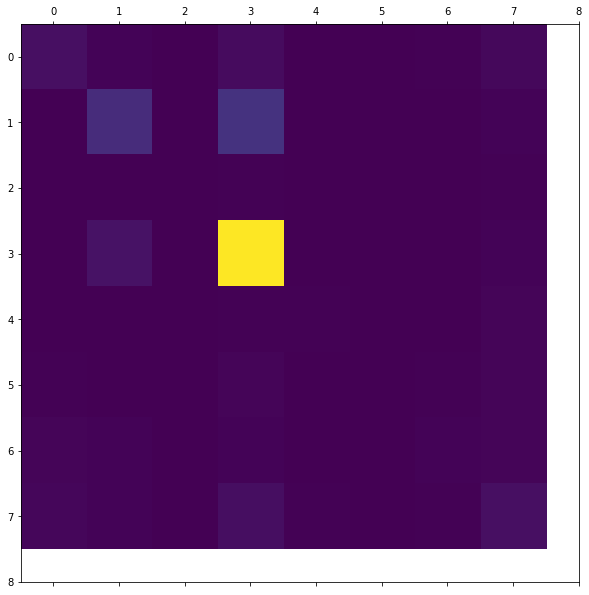

In [53]:
plot_confusion_matrix(confusion_matrix(y_test, y_test_predict2))

In [57]:
unique_label = np.unique(y_test)
resultDF = pd.DataFrame(confusion_matrix(y_test, y_test_predict2, labels=unique_label), index=['true:{:}'.format(x) for x in unique_label],columns=['pred:{:}'.format(x) for x in unique_label])

In [58]:
#we very rarely predict commercial, and our small commercial is very noisy. 
resultDF

,pred:Apartment,pred:Attached House,pred:Commercial,pred:Detached House,pred:Industrial,pred:Institutional,pred:Office,pred:Small Commercial
true:Apartment,70,14,1,50,0,1,8,34
true:Attached House,5,211,0,244,0,0,1,18
true:Commercial,4,3,0,8,0,4,2,9
true:Detached House,5,79,2,1647,0,1,0,18
true:Industrial,1,2,0,8,8,1,2,22
true:Institutional,12,4,0,24,2,2,7,20
true:Office,21,13,0,19,1,2,19,24
true:Small Commercial,27,19,0,61,8,2,11,66


# Classification using a neural network

In [138]:
X = labeledDF.loc[:, labeledDF.columns != 'Building_Typology']
y = labeledDF.loc[:, labeledDF.columns == 'Building_Typology']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random.randint(1,1000))

In [139]:
scaler = StandardScaler()  
# Don't cheat - fit only on training data
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
# apply same transformation to test data
X_test = scaler.transform(X_test)

C:\Anaconda\envs\warmup\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Anaconda\envs\warmup\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
C:\Anaconda\envs\warmup\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [149]:
clf6 = MLPClassifier(solver='lbfgs', alpha=0.01, hidden_layer_sizes=(100, 500), random_state=random.randint(1,1000))
clf6.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 500), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=197, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [150]:
# predict on train and test set (neural net)
y_train_predict = clf6.predict(X_train)
y_test_predict = clf6.predict(X_test)

# calculate train and test accuracy
train_accuracy = accuracy_score(y_train, y_train_predict)
test_accuracy = accuracy_score(y_test, y_test_predict)

# report results
print("Train accuracy: {}".format(train_accuracy))
print("Test accuracy: {}".format(test_accuracy))
#not that good all in all, definitely need to do heirarchical

Train accuracy: 0.782778864971
Test accuracy: 0.702493853179


## Breaking out prediction into heirarchical steps

In [104]:
#building a new DF for predicting higher-level class
topLevelDF = labeledDF.copy()
topLevelDF['class'] = "non-domestic"
topLevelDF.loc[topLevelDF.Building_Typology == "Detached House", 'class'] = 'domestic'
topLevelDF.loc[topLevelDF.Building_Typology == "Attached House", 'class'] = 'domestic'
topLevelDF = topLevelDF.drop(['Building_Typology'], axis=1)

#defining new testing and training sets
X = topLevelDF.loc[:, topLevelDF.columns != 'class']
y = topLevelDF.loc[:, topLevelDF.columns == 'class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) #random.randint(1,1000))

### Using Logistic Regression Classifier

In [84]:
clf3 = LogisticRegression(C=1.0).fit(X_train, y_train)
clf3.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [99]:
#WITH LAT AND LON SECTOR
# predict on train and test set (random forest)
y_train_predict = clf3.predict(X_train)
y_test_predict = clf3.predict(X_test)

# calculate train and test accuracy
train_accuracy = accuracy_score(y_train, y_train_predict)
test_accuracy = accuracy_score(y_test, y_test_predict)

# report results
print("Train accuracy: {}".format(train_accuracy))
print("Test accuracy: {}".format(test_accuracy))
#worse with this, oof

Train accuracy: 0.896281800391
Test accuracy: 0.895328415876


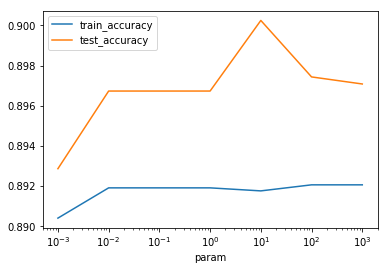

In [101]:
#hyperparameter tuning the logistic regression classifier
param_df = hyperparameter_Reg(X, y)
param_df.plot(x="param", y=["train_accuracy", "test_accuracy"], logx=True)

### Using Random Forest Classifier

In [81]:
clf3 = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=42)

In [82]:
clf3.fit(X_train, y_train)

C:\Anaconda\envs\warmup\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [83]:
#WITH LAT AND LON SECTOR
# predict on train and test set (random forest)
y_train_predict = clf3.predict(X_train)
y_test_predict = clf3.predict(X_test)

# calculate train and test accuracy
train_accuracy = accuracy_score(y_train, y_train_predict)
test_accuracy = accuracy_score(y_test, y_test_predict)

# report results
print("Train accuracy: {}".format(train_accuracy))
print("Test accuracy: {}".format(test_accuracy))
#not exceptional performance, can we really not get into the high 90s for this?

Train accuracy: 0.945506548246
Test accuracy: 0.912539515279


In [111]:
#Random Forest Appears to be the best, hyperparameter tuning over a reasonable set of parameters
hyperparameter_RanFor(X, y)
#best performance is around 10 depth with 1500 estimators

C:\Anaconda\envs\warmup\lib\site-packages\ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


,Number of Estimators,Max Depth,train_accuracy,test_accuracy
0,1500,10,0.944754,0.914296
1,1500,15,0.959657,0.913593
2,1500,20,0.971850,0.913242


### Using Naive Bayes (all 3 major variants)

In [88]:
clf_MN = MultinomialNB().fit(X_train, y_train)
clf_GS = GaussianNB().fit(X_train, y_train)
clf_BL = BernoulliNB().fit(X_train, y_train)

In [89]:
clf_MN.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [91]:
clf_GS.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [90]:
clf_BL.fit(X_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [94]:
#WITH LAT AND LON SECTOR
# predict on train and test set (random forest)
y_train_predict = clf_BL.predict(X_train)
y_test_predict = clf_BL.predict(X_test)

# calculate train and test accuracy
train_accuracy = accuracy_score(y_train, y_train_predict)
test_accuracy = accuracy_score(y_test, y_test_predict)

# report results
print("Train accuracy: {}".format(train_accuracy))
print("Test accuracy: {}".format(test_accuracy))
#not exceptional performance, can we really not get into the high 90s for this?
#MN has roughly 86% test accuracy
#GS has roughly 88% test accuracy
#BL has roughly 79% test accuracy

Train accuracy: 0.794520547945
Test accuracy: 0.794871794872


# Typology Classification in domestic/non-domestic

In [6]:
topLevelDF = labeledDF.copy()
topLevelDF['class'] = "non-domestic"
topLevelDF.loc[topLevelDF.Building_Typology == "Detached House", 'class'] = 'domestic'
topLevelDF.loc[topLevelDF.Building_Typology == "Attached House", 'class'] = 'domestic'

domesticDF = topLevelDF.loc[topLevelDF['class'] == "domestic"].drop(['class'],axis=1).copy()
nonDomesticDF = topLevelDF.loc[topLevelDF['class'] == "non-domestic"].drop(['class'],axis=1).copy()

### Training on the Domestic Typologies

In [124]:
X = domesticDF.loc[:, domesticDF.columns != 'Building_Typology']
y = domesticDF.loc[:, domesticDF.columns == 'Building_Typology']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) #random.randint(1,1000))

clf4 = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=42)
clf4.fit(X_train, y_train)

y_train_predict = clf4.predict(X_train)
y_test_predict = clf4.predict(X_test)

# calculate train and test accuracy
train_accuracy = accuracy_score(y_train, y_train_predict)
test_accuracy = accuracy_score(y_test, y_test_predict)

# report results
print("Train accuracy: {}".format(train_accuracy))
print("Test accuracy: {}".format(test_accuracy))

C:\Anaconda\envs\warmup\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Train accuracy: 0.910786387233
Test accuracy: 0.867653656348


In [125]:
unique_label = np.unique(y_test)
resultDF = pd.DataFrame(confusion_matrix(y_test, y_test_predict, labels=unique_label), index=['true:{:}'.format(x) for x in unique_label],columns=['pred:{:}'.format(x) for x in unique_label])

In [126]:
resultDF

,pred:Attached House,pred:Detached House
true:Attached House,211,200
true:Detached House,95,1723


### Training on Non-Domestic Typologies

In [8]:
X = nonDomesticDF.loc[:, domesticDF.columns != 'Building_Typology']
y = nonDomesticDF.loc[:, domesticDF.columns == 'Building_Typology']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) #random.randint(1,1000))

scaler = StandardScaler()  
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)

clf5 = RandomForestClassifier(n_estimators=2000, max_depth=10, random_state=42)
#clf5 = MLPClassifier(solver='lbfgs', alpha=0.01, hidden_layer_sizes=(100, 50), random_state=random.randint(1,1000))
clf5.fit(X_train, y_train)

y_train_predict = clf5.predict(X_train)
y_test_predict = clf5.predict(X_test)



# calculate train and test accuracy
train_accuracy = accuracy_score(y_train, y_train_predict)
test_accuracy = accuracy_score(y_test, y_test_predict)

# report results
print("Train accuracy: {}".format(train_accuracy))
print("Test accuracy: {}".format(test_accuracy))
#look like massive overfitting!
#Random Forest, ~40% accuracy
#MLP, ~32% accuracy

C:\Anaconda\envs\warmup\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  import sys
C:\Anaconda\envs\warmup\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
C:\Anaconda\envs\warmup\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':


Train accuracy: 0.883495145631
Test accuracy: 0.427184466019


In [9]:
unique_label = np.unique(y_test)
resultDF = pd.DataFrame(confusion_matrix(y_test, y_test_predict, labels=unique_label), index=['true:{:}'.format(x) for x in unique_label],columns=['pred:{:}'.format(x) for x in unique_label])

In [14]:
X

,MIN_HEIGHT,MAX_HEIGHT,AVG_HEIGHT,SHAPE_LENG,SHAPE_AREA,Simple Volume,Simple Surface Area,Latitude Quadrant,Longitude Quadrant
0,0.0000,9.8253,5.7400,61.535222,183.015834,1050.510885,10303.293150,134,49
4,0.0000,6.5232,4.3652,55.845443,123.957598,541.099705,8927.413959,130,50
6,3.3671,7.9324,6.3917,61.068415,233.001275,1489.274248,6953.727742,23,89
7,0.0000,5.2157,2.8287,72.092664,205.232819,580.542076,7817.986839,24,89
17,0.0000,2.1560,0.0670,49.573200,101.145019,6.776716,5110.582173,20,90
37,0.0000,7.3559,4.1002,137.007253,827.570865,3393.206061,17878.444612,53,76
38,0.0000,8.9499,4.6419,79.742656,396.594760,1840.953217,10165.902061,54,78
46,0.0000,6.3481,3.9839,64.241934,232.347613,925.649655,7834.208723,45,84
59,0.0000,10.0620,5.3835,198.831334,2088.626349,11244.119950,27585.864459,51,72
60,0.0000,6.5458,3.9654,89.005506,383.901597,1522.323394,11359.992439,54,75


In [10]:
resultDF
#apartment and Small commercial are fairly dominant, this is interesting. Can we regroup the categories and see if this is impactful?

,pred:Apartment,pred:Commercial,pred:Industrial,pred:Institutional,pred:Office,pred:Small Commercial
true:Apartment,110,0,0,1,7,47
true:Commercial,9,0,1,2,3,25
true:Industrial,6,0,10,1,0,22
true:Institutional,26,0,2,4,6,40
true:Office,40,0,1,0,24,35
true:Small Commercial,57,0,5,3,15,116


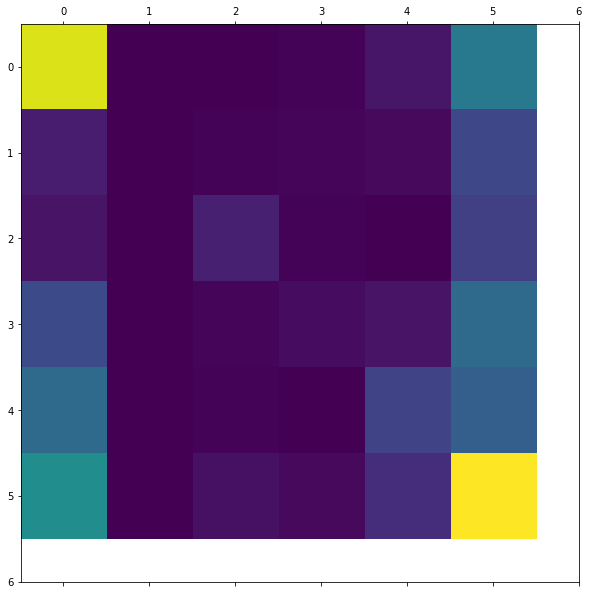

In [13]:
plot_confusion_matrix(confusion_matrix(y_test, y_test_predict))

# Non-Domestic Typology Reshuffling